In [7]:
#from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from statsmodels.tsa.stattools import adfuller
from Data import Data
from datetime import datetime

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import AgglomerativeClustering, DBSCAN

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

plt.rcParams["figure.figsize"] = (5,5)

from pandas_datareader import wb

import seaborn as sns

from sklearn import preprocessing

import seaborn as sns

plt.rcParams["figure.figsize"] = (20,10)

In [8]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def spiParametersMle(x, dist=st.gamma):
    i = x == 0
    params = dist.fit(x[~i])
    q = len(x[i])/len(x)
    return(params, q)

def spiGeneratorMle(x, dist=st.gamma):
    i = x == 0

    params = dist.fit(x[~i])
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    G = dist.cdf(x[~i], loc=loc, scale=scale, *arg)

    q = len(x[i])/len(x)
    probabilities = np.zeros(len(x))
    probabilities[i] = q
    probabilities[~i] = q + (1 - q) * G
    result = st.norm.ppf(probabilities)
    return(result)

def spiGeneratorParamMle(x, params, q, dist=st.gamma):
    i = x == 0
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    G = dist.cdf(x[~i], loc=loc, scale=scale, *arg)

    probabilities = np.zeros(len(x))
    probabilities[i] = q
    probabilities[~i] = q + (1 - q) * G
    result = st.norm.ppf(probabilities)
    return(result)


In [10]:
def phase_averaging(data,freq = 12):
    N = len(data)
    temp = data
    result = np.zeros(N)
    averages = np.zeros(freq)
    for j in range(freq):
        Idx = np.arange(j,N,freq)
        averages[j] = temp[Idx].mean()
        result[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
    return(result, averages)

def deseasonalize_NoStd(data,freq=12):
    n  = data.shape[1]
    N  = data.shape[0]
    averages = np.zeros((freq,n))
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = data[:,i]
        result = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            averages[j,i] = temp[Idx].mean()
            result[Idx] = temp[Idx] - temp[Idx].mean()
        data_deseasonal[:,i] = result
    return(data_deseasonal,averages)


def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))


In [11]:
level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

result = np.load("ET_data.npy")
result = pd.DataFrame(result)

rolling_n = 12
f = 12
n = 30

RFThree = result.rolling(rolling_n).apply(sum)
RFThree = RFThree.iloc[rolling_n - 1:,:]

N = RFThree.shape[0]

d3 = N - (n*f + 1)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if sys.path[0] == '':


In [18]:
dists = [st.gumbel_r, st.invgauss, st.lognorm, st.gamma, st.genextreme, st.dweibull]

In [19]:
names = ["gumbel_r", "invgauss", "lognorm", "gamma", "genextreme", "dweibull" ]

In [ ]:
for i in range(len(dists)):    
    result_index = []
    for k in range(d3):
        onset = k
        end = k + (n*f - (rolling_n - 1))

        a = RFThree.iloc[onset:end,:].values
        b = RFThree.iloc[end + (rolling_n - 1),:].values
        n_a = a.shape[1]
        index = np.zeros(n_a)

        for i in range(n_a):
            x = a[:,i]
            params,q = spiParametersMle(x,st.pearson3)
            r = spiGeneratorParamMle([b[i]], params, q, dists[i])
            index[i] = r

        result_index.append(index)
    filename = "ET_{}.npy".format(names[i])
    np.save(filename,np.array(result_index))

In [182]:
level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

result = np.load("ET_data.npy")
result = pd.DataFrame(result)

rolling_n = 12
f = 12
n = 30

RFThree = result.rolling(rolling_n).apply(sum)
RFThree = RFThree.iloc[rolling_n - 1:,:]


/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if sys.path[0] == '':


In [ ]:
for j in range(len(dists)):
    result_index = []
    n = RFThree.shape[1]
    index = np.zeros(n)

    for i in range(n):
        x = RFThree.iloc[:,i].values
        params,q = spiParametersMle(x, dists[j])
        index[i] = spiGeneratorParamMle(x, params, q, dists[j])

    result_index.append(index)
    filename = "ET_{}_whole.npy".format(names[j])
    np.save(filename,np.array(result_index))


In [8]:
level = 12
temporal_limits = {"time_min":datetime(1946, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [130]:
d = Data('../../nc/precip.mon.total.2.5x2.5.v2018.nc','precip',temporal_limits,missing_value=-9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

In [129]:
result.shape

(468, 3638)

In [26]:
import csv
count = list(count)
with open('ET_test.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(count)

In [12]:
level = 12
temporal_limits = {"time_min":datetime(1946, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [15]:
f = Dataset("../../nc/Brazil_precip.nc")

In [20]:
lat = f["lat"][:]

In [21]:
lon = f["lon"][:]

In [22]:
precip = f["precip"][:]

In [43]:
lat = lat[0:13]

In [44]:
lon = lon[7:19]

In [38]:
data = precip[:,:13,7:19]

In [41]:
data = data.swapaxes(0,2)

In [46]:
def unflatten_refine(data,lon,lat,missing_value = -9.969209968386869e+36):
        """
        Converts 3D spatio-temporal data inot 2D data
        
        Parameters
        ----------
        data : 3D matrix, shape (longtitude, latitude, time)
        
        Returns
        -------
        result : 2D matrix, shape (time, locaion)
            
        """
        result = []
        index2d = {}
        lat_list = []
        lon_list = []
        r = data.shape[0]
        c = data.shape[1]
        for i in range(r):
            for j in range(c):
                if (not np.ma.is_masked(data[i,j,:])) and data[i,j,-1] != (missing_value) and data[i,j,-1] > -1000 :
                    result.append(data[i,j,:])
                    index2d[len(result)-1] = (i,j)  
                    lon_list.append(lon[i])
                    lat_list.append(lat[j])
        result = np.transpose(np.matrix(result))
        return(result, index2d, lon_list, lat_list)

In [47]:
result, index2d, lon_list, lat_list = unflatten_refine(data,lon,lat)

In [48]:
result.shape

(840, 139)

In [243]:
d = Data('../../nc/Aus_SE.nc','precip',temporal_limits,missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

In [189]:
coordinates = list(zip(lat_list,lon_list))

In [183]:
dic = rg.search(coordinates)

In [147]:
import geocoder

In [148]:
results = geocoder.google('37, -120', reverse = True)

In [149]:
print(results.current_result)

None


In [122]:
results.reverse

<bound method MutableSequence.reverse of <[REQUEST_DENIED] Google - Geocode [empty]>>

In [184]:
country = []
for i in range(len(dic)):
    country.append(dic[i].get('cc'))

In [50]:
Cal_index = np.where(np.array(country)== 'California')[0]

In [51]:
Cal_data = result[:-1,Cal_index]

In [244]:
result.shape

(840, 584)

In [161]:
weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))

for i in range(len(weights)):
    result[:,i] = weights[i] * result[:,i]

In [167]:
result = np.transpose(result)

In [168]:
c = np.corrcoef(result)

In [169]:
c.shape

(336, 336)

In [50]:
np.save("Brazil_data_3.npy",result)

In [172]:
c = np.nan_to_num(c)
eigenValues, eigenVectors = np.linalg.eig(c)
idx = eigenValues.argsort()[::-1]
eigenValues = eigenValues[idx]

print(np.count_nonzero(eigenValues > (1+math.sqrt(result.shape[0]/result.shape[1]))**2))

7


In [176]:
result = pd.DataFrame(result)

rolling_n = 12
f = 12
n = 30

RFThree = result.rolling(rolling_n).apply(sum)
RFThree = RFThree.iloc[rolling_n - 1:,:]

N = RFThree.shape[0]

d3 = N - (n*f + 1)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  import sys


In [177]:
result_index = []
for k in range(d3):
    onset = k
    end = k + (n*f - (rolling_n - 1))

    a = RFThree.iloc[onset:end,:].values
    b = RFThree.iloc[end + (rolling_n - 1),:].values
    n_a = a.shape[1]
    index = np.zeros(n_a)

    for i in range(n_a):
        x = a[:,i]
        params,q = spiParametersMle(x)
        r = spiGeneratorParamMle([b[i]], params, q)
        index[i] = r

    result_index.append(index)

np.save("Cal_gamma.npy",np.array(result_index))


KeyboardInterrupt: 

In [95]:
result = pd.DataFrame(ET_data)

rolling_n = 12
f = 12
n = 30

RFThree = result.rolling(rolling_n).apply(sum)
RFThree = RFThree.iloc[rolling_n - 1:,:]

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  import sys


In [ ]:
result_index = []
n = RFThree.shape[1]

for i in range(n):
    x = RFThree.iloc[:,i].values
    params,q = spiParametersMle(x, dists[j])
    result_index.append(spiGeneratorParamMle(x, params, q, dists[j]))




In [97]:
x = RFThree.iloc[:,0].values

In [98]:
params,q = spiParametersMle(x)

In [99]:
r = spiGeneratorParamMle(x, params, q)

In [104]:
r.std()

0.9999992321024448

In [236]:
Cal_gamma = np.load("Brazil_gamma.npy")
N = Cal_gamma.shape[0]
n_nodes = Cal_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(Cal_gamma[i,:] <= extremes_treshold))

In [237]:
count = np.array(count)/n_nodes

In [238]:
N

468

In [239]:
df_count = pd.DataFrame(count,
                  columns=["number"],
                  index=pd.date_range("19770101", periods=len(count), freq='MS'))

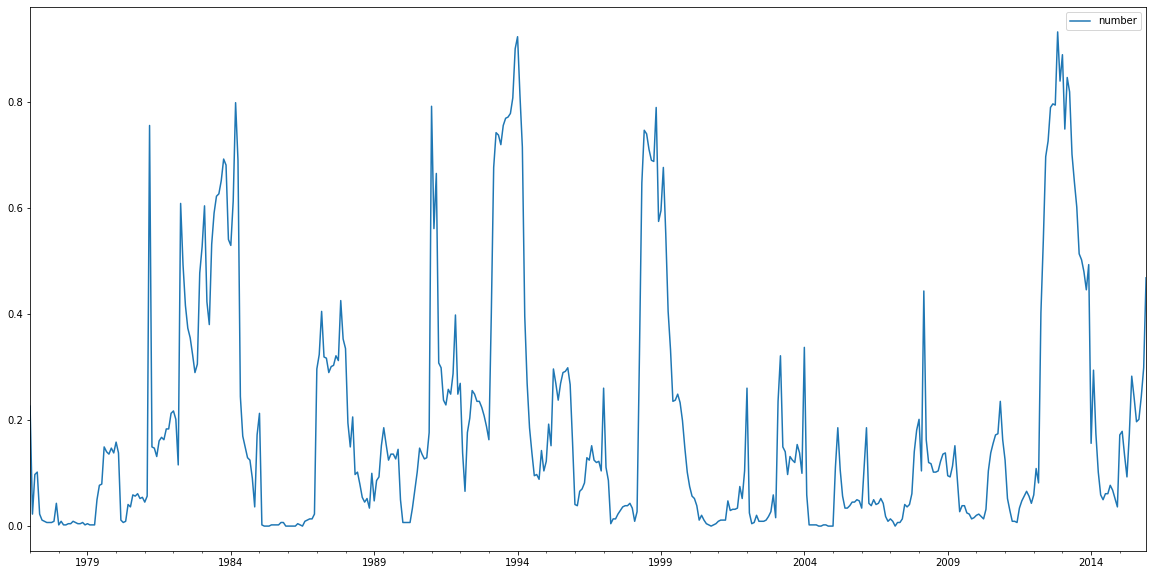

In [240]:
df_count.plot()

In [193]:
df_count.to_csv("ET_count_ex.csv")

In [196]:
ET_gamma = np.load("../ET/ET_gamma_whole.npy")
N = ET_gamma.shape[0]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.ma.masked_invalid(ET_gamma[i,:]).sum())

In [12]:
df_extreme = pd.DataFrame({"count":count})
df_extreme = df_extreme.rolling(12).sum()
Idx = np.arange(11,N,12)
df_extreme = df_extreme.iloc[Idx,:]
year = np.arange(1977,2016)
df_extreme["year"] = year

In [13]:
et = pd.read_csv("Data_6.csv")
et  = et.iloc[:,[0,4]]
et = et.dropna()
et["year"] = pd.to_numeric(et["year"])

In [14]:
pop = [25013626,27652709,31036662,38142674,43329231,46272299,60697443,64343013,72170584,76346311,82916235,85233913,
      90139929,92726985,100835458]
et["POP"] = pop
et["drought"] = et["Affected"]/et["POP"]

In [15]:
data_et = et.drop(['Affected', 'POP'], axis=1)

In [16]:
df_extreme = df_extreme.merge(data_et, how='left')
df_extreme = df_extreme.set_index("year")
df_extreme = df_extreme.fillna(0)
df_extreme = (df_extreme - df_extreme.mean())/df_extreme.std()

In [17]:
df_extreme.plot()

NameError: name 'df_extreme' is not defined

In [18]:
df_extreme.corr()

,count,drought
count,1.00000,0.16064
drought,0.16064,1.00000


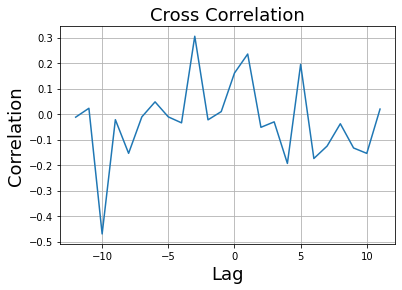

In [19]:
xcov_monthly = [ef.crosscorr(df_extreme["count"],df_extreme["drought"],lag=i) for i in range(-12,12)]
lag = np.arange(-12,12)

fig = plt.figure()
plt.plot(lag, xcov_monthly)
plt.title("Cross Correlation", fontsize = 18)
plt.ylabel("Correlation", fontsize = 18)
plt.xlabel("Lag", fontsize = 18)
plt.grid()
#filename = "../plots/IDD/Corr_{}.png".format(cluster)
#fig.savefig(filename)

In [39]:
def deseasonalize(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = np.copy(data[:,i])
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)
    return(data_deseasonal)


In [40]:
ET_gamma = np.load("ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

In [56]:
level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

name = ["../../nc/precip.mon.total.2.5x2.5.v2018.nc","../../nc/pres.mon.mean.nc","../../nc/air.mon.mean.nc","../../nc/sst.mnmean.nc"]
code = ["precip", "pres", "air", "sst"]
missing = [-9.96921e+36, -9.96921e+36, -9.96921e+36,-9.96921e+36]
n_components = [87, 64, 82, 76]

In [57]:
df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]
               
    data = pd.DataFrame(result)

    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(scaled_data)

    df_cluster.append(pca_model.transform(data))

In [58]:
extremes_name  = ["n_extremes"]

precip_name  = []
for i in range(n_components[0]):
    precip_name.append("PRECIP_%d"%i)
    
pres_name  = []
for i in range(n_components[1]):
    pres_name.append("PRES_%d"%i)
    
sat_name  = []
for i in range(n_components[2]):
    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[3]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + precip_name + pres_name + sat_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))
result_precip = np.matrix(df_cluster[0])
result_pres = np.matrix(df_cluster[1])
result_sat = np.matrix(df_cluster[2])
result_sst = np.matrix(df_cluster[3])


result = np.concatenate((result_extremes,result_precip, result_pres, result_sat, result_sst), axis=1)
result = np.matrix(result)

In [38]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = pcmci.run_pcmci(tau_max=12, pc_alpha=None)

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.01)

q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')


pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)

In [ ]:
data_pre = pd.DataFrame(result)

In [125]:
ET_gamma_whole = np.load("ET_gamma_whole.npy")
N = ET_gamma_whole.shape[0]
n_nodes = ET_gamma_whole.shape[1]
extremes_treshold = -1
count_whole = []
for i in range(N):
    count_whole.append(np.count_nonzero(ET_gamma_whole[i,:] <= extremes_treshold))

In [ ]:
ET_gamma_whole = np.load("ET_gamma_whole.npy")

# SPI

In [70]:
ET_data = np.load("ET_data.npy")

In [71]:
ET_gamma = np.load("ET_gamma.npy")

In [72]:
index = np.isinf(ET_gamma)
ET_gamma[index]= 2.3263478740408408

In [73]:
ET_gamma.shape

(468, 303)

In [74]:
data = np.transpose(ET_gamma)

In [75]:
eigenValues, eigenVectors = np.linalg.eig(np.corrcoef(data))
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]

np.count_nonzero(eigenValues > (1+math.sqrt(data.shape[0]/data.shape[1]))**2)

18

In [76]:
n_components_spi = 18

data_spi = pd.DataFrame(data)


#scale = StandardScaler()
#scaled_data = scale.fit_transform(data_spi)

pca = PCA(n_components=n_components_spi)
pca_model = pca.fit(data_spi)
df_cluster_spi = pca_model.transform(data_spi)


#Matrix = pd.DataFrame(np.transpose(pca_model.components_))
#Matrix = (Matrix - Matrix.mean())/Matrix.std()
loading_spi = pf.varimax(np.transpose(pca_model.components_), q=1000)
for z in range(loading_spi.shape[1]):
    loading_spi[:,z] = loading_spi[:,z] / np.linalg.norm(loading_spi[:,z])
loading_spi = pd.DataFrame(loading_spi)

In [77]:
lon_list = np.array(lon_list)
lat_list = np.array(lat_list)

In [78]:
lon_spi_list = lon_list[ET_index]

NameError: name 'ET_index' is not defined

In [169]:
lat_spi_list = lat_list[ET_index]

In [18]:
clusters = loading_spi.idxmax(axis=1)
df_spi = pd.DataFrame({"lons":lon_spi_list,"lats":lat_spi_list,"clusters":clusters.values.tolist()})

lon_temp = df_spi["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_spi["lons"].vlues = lon_temp

In [179]:
lat_spi  = np.array(list(set(lat_spi_list)))
lat_spi = np.sort(lat_spi)
lon_spi  = np.array(list(set(lon_spi_list)))
lon_spi = np.sort(lon_spi)

In [183]:
lat_spi

array([ 3.25,  3.75,  4.25,  4.75,  5.25,  5.75,  6.25,  6.75,  7.25,
        7.75,  8.25,  8.75,  9.25,  9.75, 10.25, 10.75, 11.25, 11.75,
       12.25, 12.75, 13.25, 13.75, 14.25], dtype=float32)

In [181]:
lon_spi

array([32.75, 33.25, 33.75, 34.25, 34.75, 35.25, 35.75, 36.25, 36.75,
       37.25, 37.75, 38.25, 38.75, 39.25, 39.75, 40.25, 40.75, 41.25,
       41.75, 42.25, 42.75, 43.25], dtype=float32)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


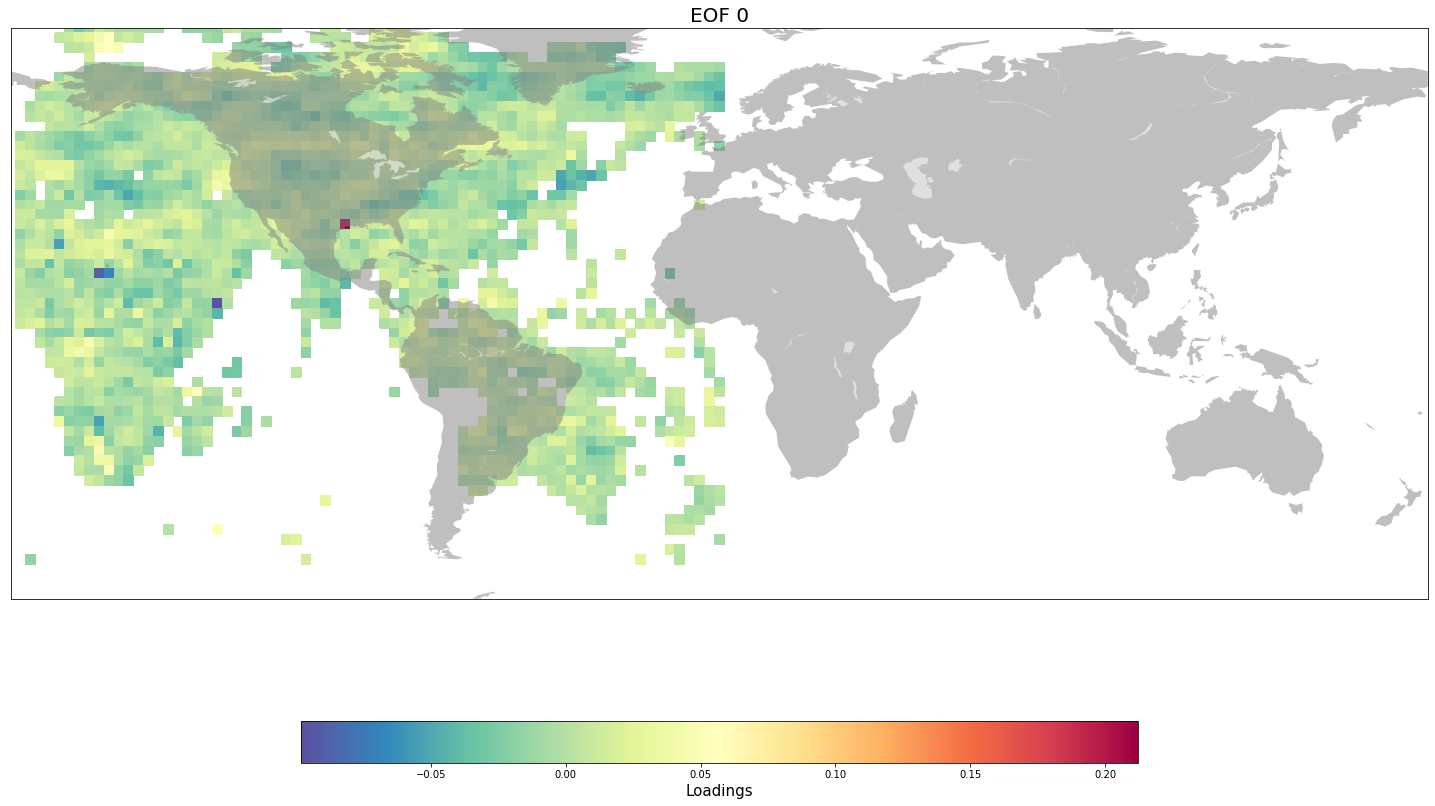

In [23]:
pc = 8
df_spi["pc"] = loading_spi[pc]


#lon = np.arange(-178.75,179.0,2.5)
#lon_spi = np.arange(-180,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_spi),len(lon_spi)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_spi[(df_spi.lats == lat_spi[i]) & (df_spi.lons == lon_spi[j])].clusters.values.size == 0:
            deg[i,j] = df_spi[(df_spi.lats == lat_spi[i]) & (df_spi.lons == lon_spi[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon[0], llcrnrlat=lat[-1],urcrnrlon=lon[-1],urcrnrlat=lat[0])
map =Basemap(llcrnrlon=25, llcrnrlat=0,urcrnrlon=50,urcrnrlat=20)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#map.drawcountries()
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon_spi, lat_spi)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('Loadings', fontsize = 15)
plt.title("EOF %d"%(pc),fontsize = 20)
#plt.savefig("EOF%d.png"%(pc+1))
plt.show()

# Global SPI:

In [85]:
level = 12
temporal_limits = {"time_min":datetime(1946, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) }
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

n_components_spi = 46

d = Data('../../nc/precip.mon.total.2.5x2.5.v2018.nc','precip',temporal_limits,missing_value=-9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

result = np.load("World_gamma.npy")
weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
for i in range(len(weights)):
    result[:,i] = weights[i] * result[:,i]

In [86]:
data_spi = pd.DataFrame(result)


#scale = StandardScaler()
#scaled_data = scale.fit_transform(data_spi)

pca = PCA(n_components=n_components_spi)
pca_model = pca.fit(data_spi)
df_cluster_spi = pca_model.transform(data_spi)


#Matrix = pd.DataFrame(np.transpose(pca_model.components_))
#Matrix = (Matrix - Matrix.mean())/Matrix.std()
loading_spi = pf.varimax(np.transpose(pca_model.components_), q=1000)
#loading_spi = np.transpose(pca_model.components_)
for z in range(loading_spi.shape[1]):
    loading_spi[:,z] = loading_spi[:,z] / np.linalg.norm(loading_spi[:,z])
loading_spi = pd.DataFrame(loading_spi)

In [87]:
clusters = loading_spi.idxmax(axis=1)
df_spi = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clusters.values.tolist()})

lon_temp = df_spi["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_spi["lons"].vlues = lon_temp

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


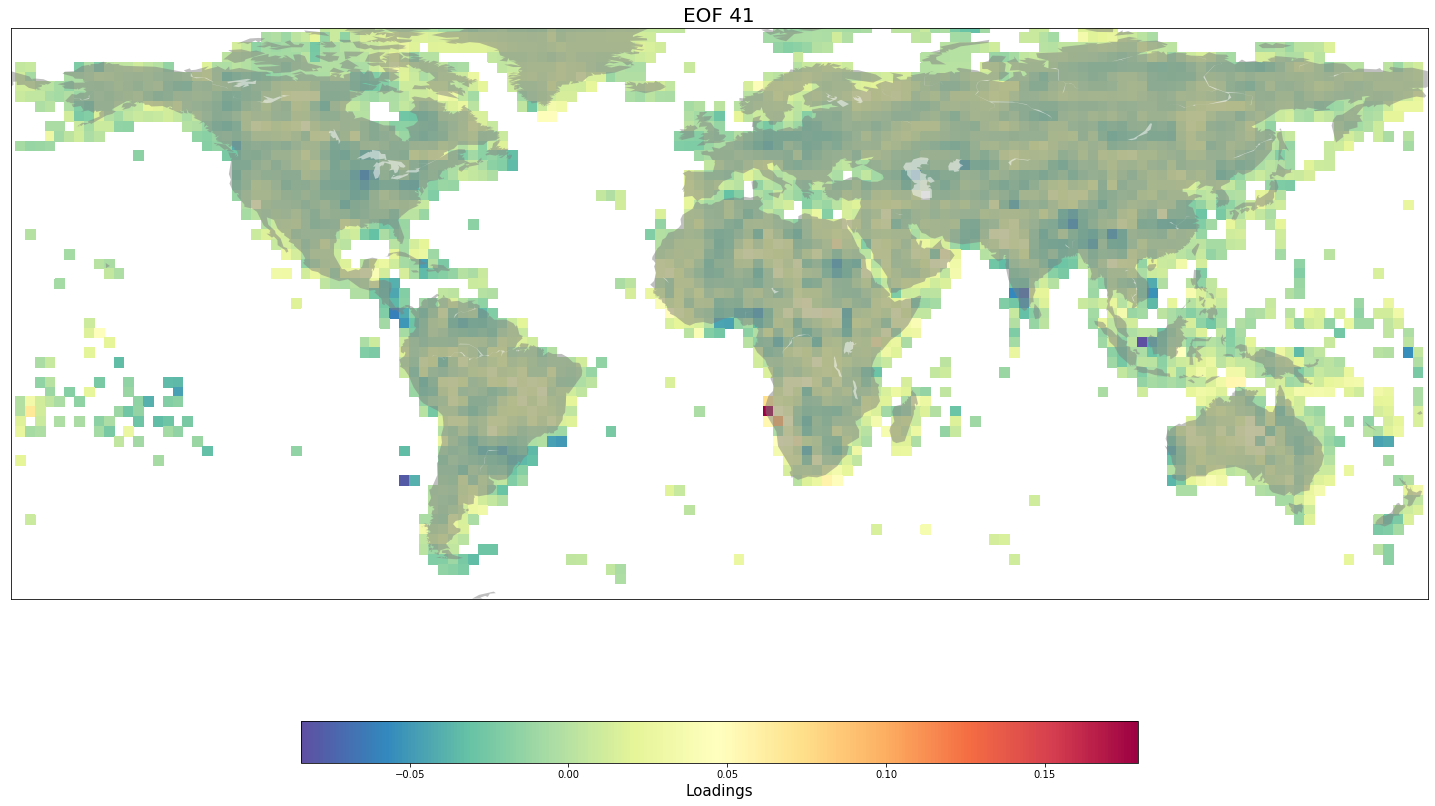

In [94]:
pc = 40
df_spi["pc"] = loading_spi[pc]

#lon1 = np.arange(-178.75,179.0,2.5)
lon1 = np.arange(-178.75,180,2.5)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat),len(lon1)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_spi[(df_spi.lats == lat[i]) & (df_spi.lons == lon1[j])].clusters.values.size == 0:
            deg[i,j] = df_spi[(df_spi.lats == lat[i]) & (df_spi.lons == lon1[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
map=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1, lat)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('Loadings', fontsize = 15)
plt.title("EOF %d"%(pc+1),fontsize = 20)
#plt.savefig("EOF%d.png"%(pc+1))
plt.show()

In [82]:
df_cluster_spi.shape

(468, 46)

In [83]:
np.save("df_cluster_spi_global.npy",df_cluster_spi)

In [207]:
result_spi = np.array(df_cluster_spi)
#result_extremes = result_extremes.reshape((len(count),1))
#result_precip = np.array(df_cluster[0])
#result_pres = np.array(df_cluster[1])
#result_sat = np.array(df_cluster[2])
result_sst = np.array(df_cluster_sst)


result = np.concatenate((result_spi,result_sst), axis=1)
result = np.array(result)

In [204]:
df_cluster_sst.shape

(841, 76)

In [ ]:
ET_gamma = np.load("ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

In [19]:
n_components_pre = 87
level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [99]:
pre = Data('../../nc/precip.mon.total.2.5x2.5.v2018.nc','precip',temporal_limits, missing_value= -9.96921e+36)

result_pre = pre.get_data()
lon_pre_list = pre.get_lon_list()
lat_pre_list = pre.get_lat_list()
lon_pre = pre.get_lon()
lat_pre = pre.get_lat()

result_pre = pf.deseasonalize(np.array(result_pre))
weights = np.sqrt(np.abs(np.cos(np.array(lat_pre_list)* math.pi/180)))
for i in range(len(weights)):
    result_pre[:,i] = weights[i] * result_pre[:,i]

data_pre = pd.DataFrame(result_pre)

#scale = StandardScaler()
#scaled_data = scale.fit_transform(data_pre)

pca = PCA(n_components=n_components_pre)
pca_model = pca.fit(data_pre)
df_cluster_pre = pca_model.transform(data_pre)

#Matrix = pd.DataFrame(np.transpose(pca_model.components_))
#Matrix = (Matrix - Matrix.mean())/Matrix.std()
loading_pre = pf.varimax(np.transpose(pca_model.components_), q=1000)
for z in range(loading_pre.shape[1]):
    loading_pre[:,z] = loading_pre[:,z] / np.linalg.norm(loading_pre[:,z])
loading_pre = pd.DataFrame(loading_pre)

#Matrix = np.transpose(pca_model.components_)
#loading_pre = pd.DataFrame(pf.varimax(Matrix, q=1000))

clusters = loading_pre.idxmax(axis=1)
df_pre = pd.DataFrame({"lons":lon_pre_list,"lats":lat_pre_list,"clusters":clusters.values.tolist()})

lon_temp = df_pre["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_pre["lons"].vlues = lon_temp

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


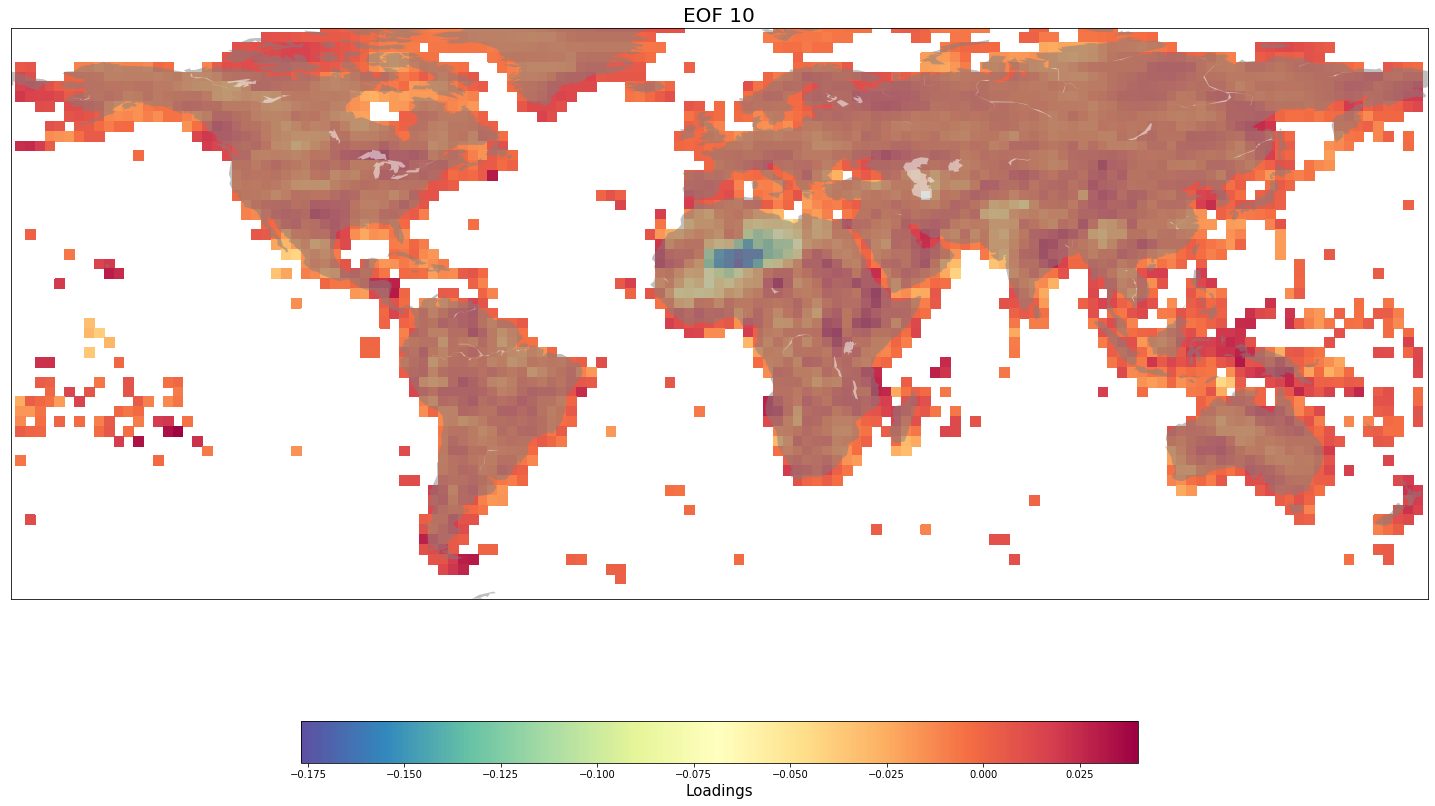

In [111]:
pc = 9
df_pre["pc"] = loading_pre[pc]

#lon1 = np.arange(-178.75,179.0,2.5)
lon1_pre = np.arange(-178.75,180,2.5)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_pre),len(lon1_pre)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_pre[(df_pre.lats == lat_pre[i]) & (df_pre.lons == lon1_pre[j])].clusters.values.size == 0:
            deg[i,j] = df_pre[(df_pre.lats == lat_pre[i]) & (df_pre.lons == lon1_pre[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
map=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_pre, lat_pre)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('Loadings', fontsize = 15)
plt.title("EOF %d"%(pc+1),fontsize = 20)
#plt.savefig("EOF%d.png"%(pc+1))
plt.show()

In [15]:
ET_gamma = np.load("ET_gamma.npy")

In [8]:
ET_gamma = np.load("ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

In [7]:
level = 12
temporal_limits = {"time_min":datetime(1974, 1, 1, 0, 0),"time_max":datetime(2012, 12, 1, 0, 0) }
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [15]:
result_sst.shape

(468, 10988)

In [9]:
n_components_sst = 76


sst = Data('../../nc/sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result_sst = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst = pf.deseasonalize(np.array(result_sst))
weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

data_sst = pd.DataFrame(result_sst)


#scale = StandardScaler()
#scaled_data = scale.fit_transform(data_sst)

pca = PCA(n_components=n_components_sst)
pca_model = pca.fit(data_sst)
df_cluster_sst = pca_model.transform(data_sst)


#Matrix = pd.DataFrame(np.transpose(pca_model.components_))
#Matrix = (Matrix - Matrix.mean())/Matrix.std()
loading_sst = pf.varimax(np.transpose(pca_model.components_), q=1000)
for z in range(loading_sst.shape[1]):
    loading_sst[:,z] = loading_sst[:,z] / np.linalg.norm(loading_sst[:,z])
loading_sst = pd.DataFrame(loading_sst)

#Matrix = np.transpose(pca_model.components_)
#loading_sst = pd.DataFrame(pf.varimax(Matrix, q=1000))


clusters = loading_sst.idxmax(axis=1)
df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list,"clusters":clusters.values.tolist()})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

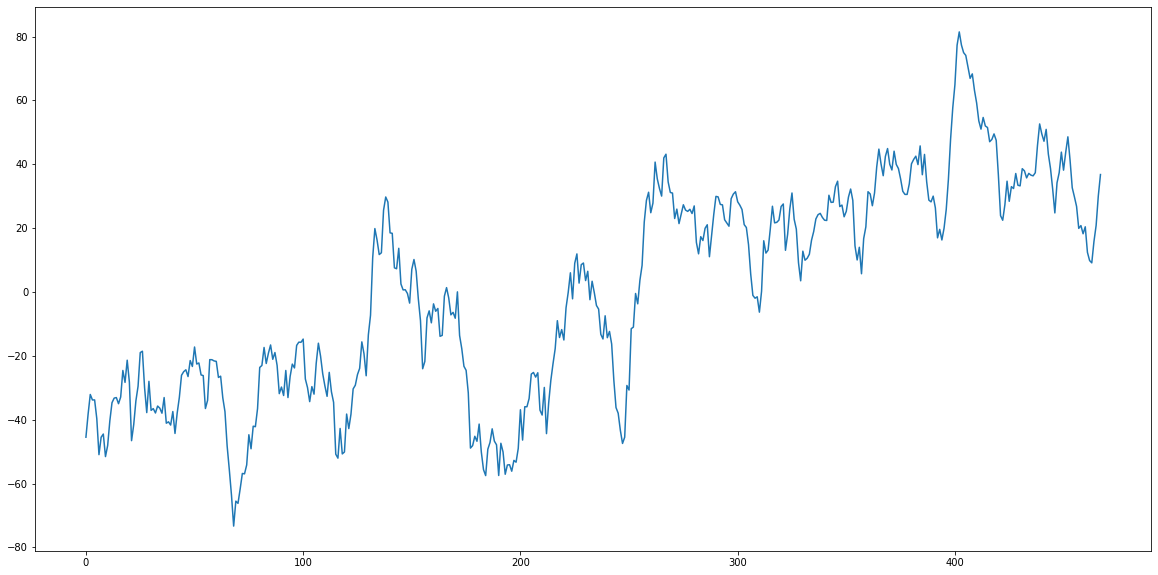

In [12]:
plt.plot(df_cluster_sst[:,0])

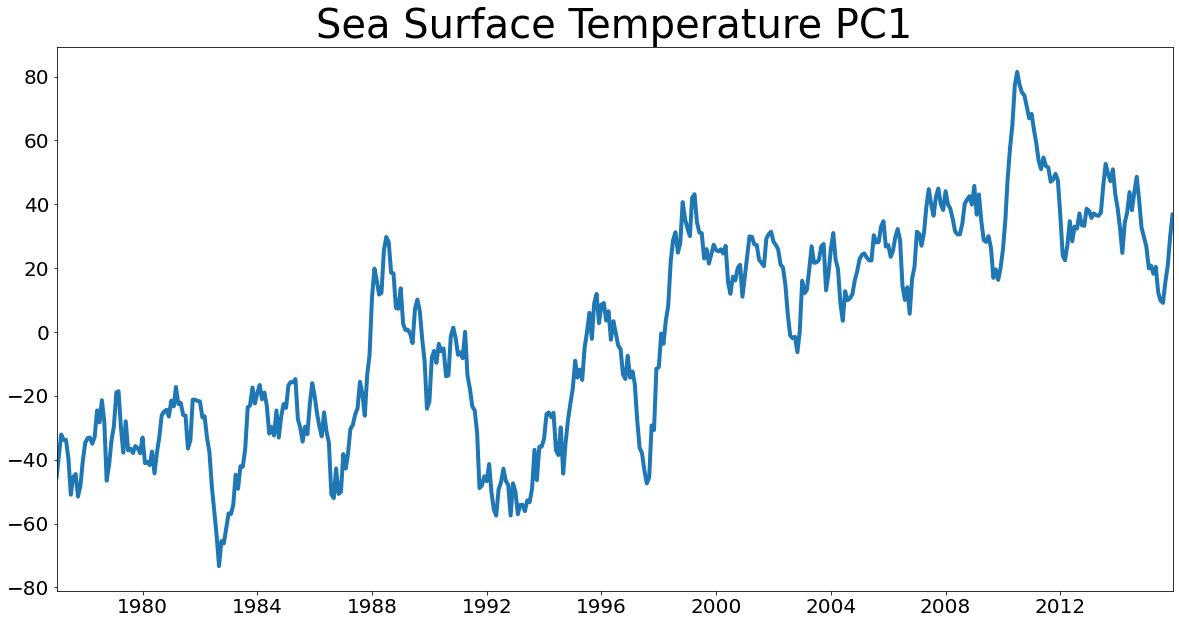

In [19]:
x = np.arange('1977-01', '2016-01', dtype='datetime64[M]')

plt.plot(x,df_cluster_sst[:,0], label = "Drought", linewidth=4.0)
plt.xlim(x[0],x[-1])
#plt.legend(prop={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.title("Sea Surface Temperature PC1", fontsize = 40)
plt.savefig("PC1.png")

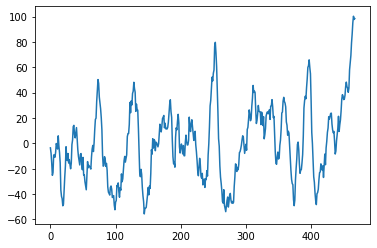

In [14]:
plt.plot(df_cluster_sst[:,1])

In [28]:
df = pd.DataFrame(count,
                  columns=["Drought"],
                  index=pd.date_range("19770101", periods=len(count), freq='MS'))

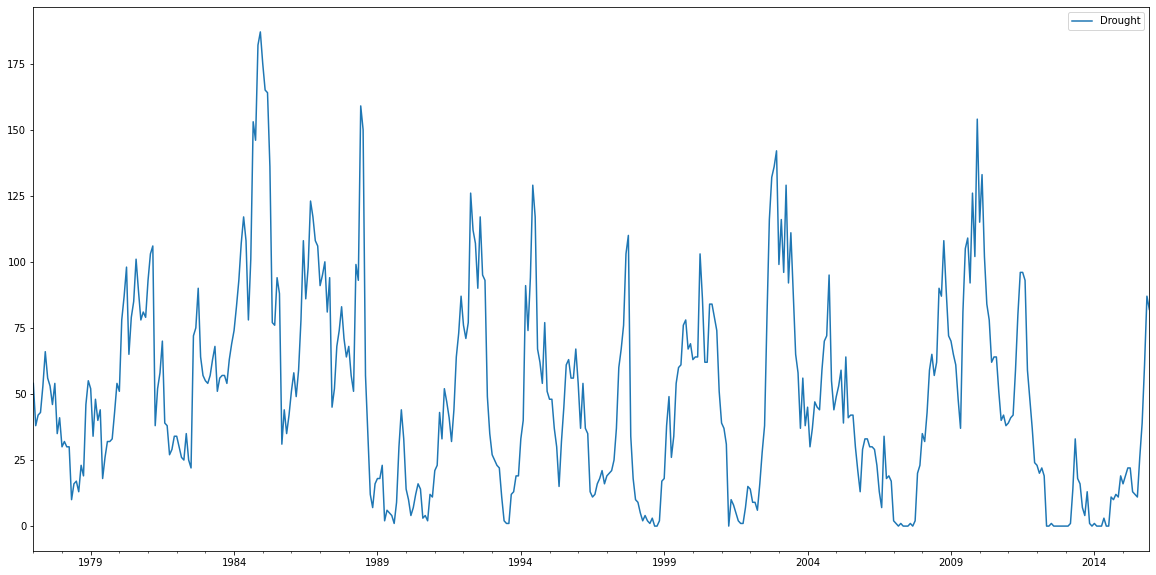

In [29]:
df.plot()

In [15]:
x = np.arange('1977-01', '2016-01', dtype='datetime64[M]')

In [19]:
count = np.array(count)/303

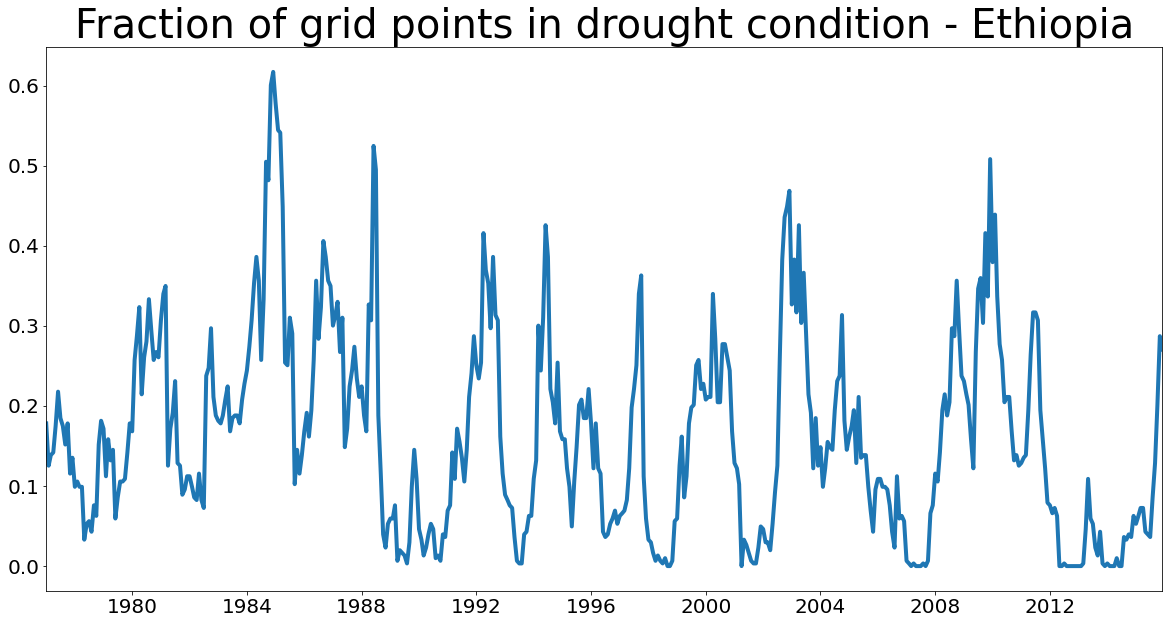

In [21]:
plt.plot(x,count, label = "Drought",linewidth=4.0)
plt.xlim(x[0],x[-1])
#plt.legend(prop={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.title("Fraction of grid points in drought condition - Ethiopia", fontsize = 40)
plt.savefig("DroughtEthiopia.png")

In [87]:
oni = pd.read_csv("ONI.csv")

In [92]:
oni_new = oni.iloc[324:792,5].values

In [94]:
oni_new.shape

(468,)

In [98]:
count = np.array(count)

In [100]:
result_extremes = np.array(count)

In [101]:
result_extremes = result_extremes.reshape((len(count),1))

In [102]:
result_oni = np.array(oni_new)

result_oni = result_oni.reshape((len(oni_new),1))

In [103]:
var_names = ["count","oni"]

In [104]:
result = np.concatenate((result_extremes,result_oni), axis=1)
result = np.array(result)

#print(result.shape)
#print(var_names)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [105]:
results = pcmci.run_pcmci(tau_max=12, pc_alpha=None)

In [106]:
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable count has 3 link(s):
        (count -1): pval = 0.00000 | val = 0.698
        (count -12): pval = 0.00000 | val = -0.270
        (count -4): pval = 0.01504 | val = 0.116

    Variable oni has 4 link(s):
        (oni -1): pval = 0.00000 | val = 0.879
        (oni -2): pval = 0.00000 | val = -0.405
        (oni -4): pval = 0.00601 | val = 0.131
        (count -5): pval = 0.00711 | val = -0.129


In [ ]:


#q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')

pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)

In [6]:
spi = np.load("count_spi.npy")

In [7]:
spi = spi/74

In [13]:
count = np.array(count)/303

In [22]:
len(spi)/12

63.0

In [23]:
27 *12

324

In [9]:
spi = spi[324:]

In [10]:
count = count[:-36]

In [11]:
x = np.arange('1977-01', '2013-01', dtype='datetime64[M]')

In [54]:
x

array(['1977-01', '1977-02', '1977-03', '1977-04', '1977-05', '1977-06',
       '1977-07', '1977-08', '1977-09', '1977-10', '1977-11', '1977-12',
       '1978-01', '1978-02', '1978-03', '1978-04', '1978-05', '1978-06',
       '1978-07', '1978-08', '1978-09', '1978-10', '1978-11', '1978-12',
       '1979-01', '1979-02', '1979-03', '1979-04', '1979-05', '1979-06',
       '1979-07', '1979-08', '1979-09', '1979-10', '1979-11', '1979-12',
       '1980-01', '1980-02', '1980-03', '1980-04', '1980-05', '1980-06',
       '1980-07', '1980-08', '1980-09', '1980-10', '1980-11', '1980-12',
       '1981-01', '1981-02', '1981-03', '1981-04', '1981-05', '1981-06',
       '1981-07', '1981-08', '1981-09', '1981-10', '1981-11', '1981-12',
       '1982-01', '1982-02', '1982-03', '1982-04', '1982-05', '1982-06',
       '1982-07', '1982-08', '1982-09', '1982-10', '1982-11', '1982-12',
       '1983-01', '1983-02', '1983-03', '1983-04', '1983-05', '1983-06',
       '1983-07', '1983-08', '1983-09', '1983-10', 

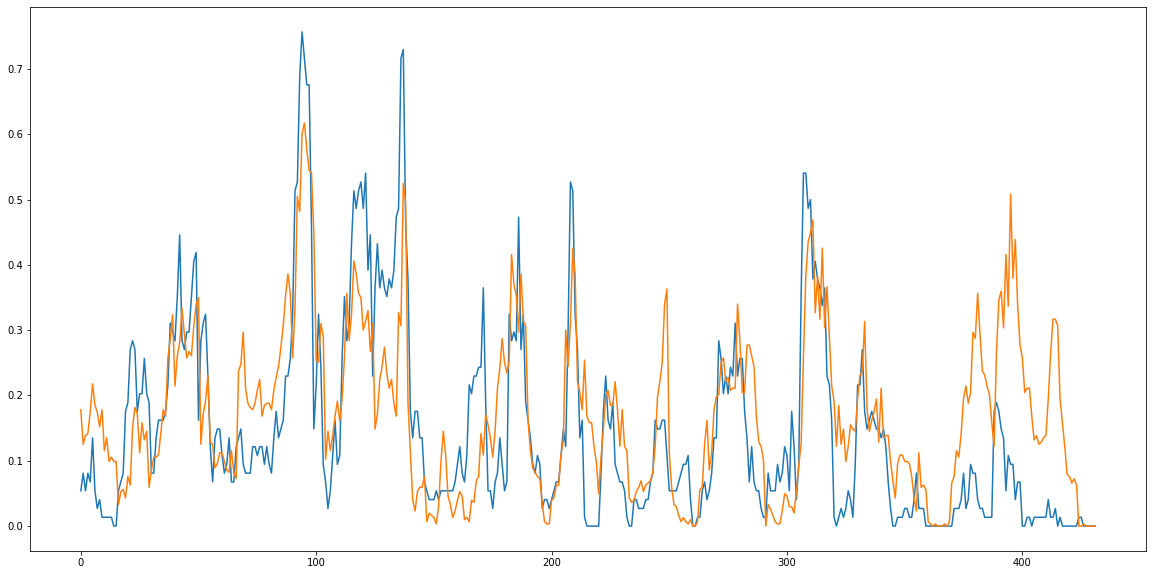

In [18]:
plt.plot(range(len(count)),spi, count)

In [15]:
np.corrcoef(spi,count)

array([[1.        , 0.66759661],
       [0.66759661, 1.        ]])

In [9]:
df = pd.DataFrame({"drought":count, "sst2":df_cluster_sst[:,1], 
                   "sst41":df_cluster_sst[:,40], "sst72":df_cluster_sst[:,71]})

In [10]:
df["drought1"] = count
df["drought12"] = count

In [11]:
df.sst2 = df.sst2.shift(12)
df.sst41 = df.sst41.shift(1)
df.sst71 = df.sst72.shift(11)
df.drought1 = df.drought1.shift(1)
df.drought12 = df.drought1.shift(12)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
df = df.dropna()

In [13]:
df

,drought,sst2,sst41,sst72,drought1,drought12
13,32,-7.848510,0.989585,-3.449286,30.0,54.0
14,30,-15.507652,-0.081156,-5.879403,32.0,38.0
15,30,-25.191986,1.641278,-2.686439,30.0,42.0
16,10,-23.034614,-1.733567,-4.684590,30.0,43.0
17,16,-9.125324,3.342970,-1.237073,10.0,53.0
...,...,...,...,...,...,...
463,26,34.922166,-1.067977,-2.875524,11.0,0.0
464,39,37.891602,1.432836,-0.979347,26.0,11.0
465,61,44.742732,-3.105194,1.964686,39.0,10.0
466,87,48.279216,-0.223769,-0.028918,61.0,12.0


In [14]:
df.to_csv("droughtSST12.csv")

In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [120]:
reg = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)

In [135]:
X = df.iloc[:,5].values
y = df.iloc[:,0].values

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [138]:
reg.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [139]:
pred = reg.predict(X_test.reshape(-1,1))

In [140]:
mean_squared_error(pred, y_test)

1652.2579083055107

In [141]:
math.sqrt(394)

19.849433241279208

In [38]:
df_norm=(df-df.mean())/df.std()

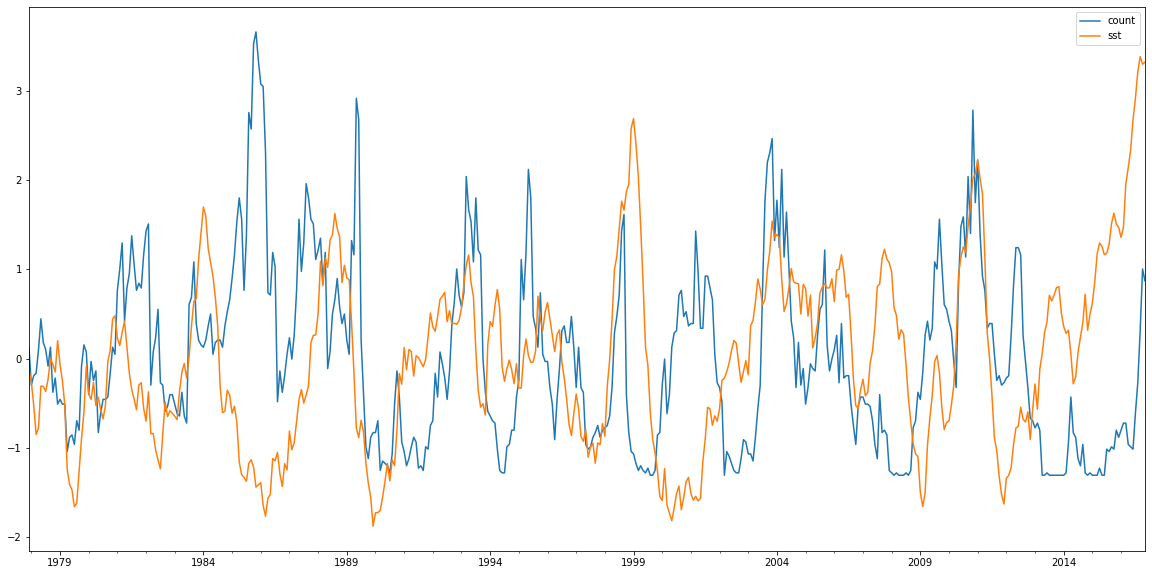

In [39]:
df_norm.plot()

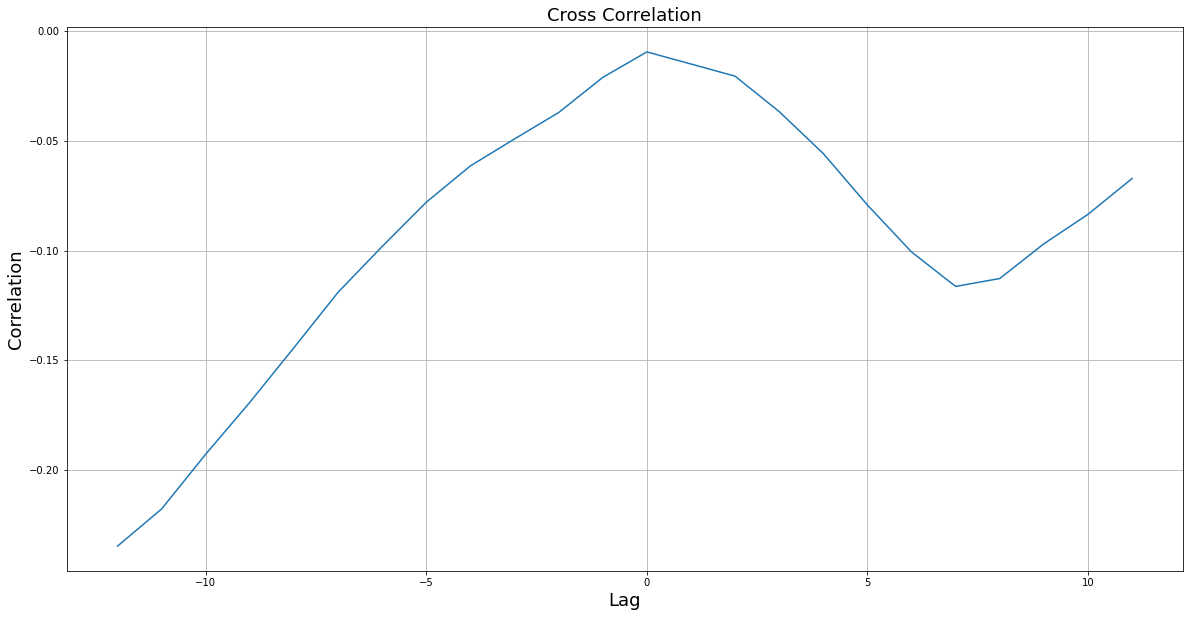

In [33]:
xcov_monthly = [ef.crosscorr(df["count"],df["sst"],lag=i) for i in range(-12,12)]
lag = np.arange(-12,12)

fig = plt.figure()
plt.plot(lag, xcov_monthly)
plt.title("Cross Correlation", fontsize = 18)
plt.ylabel("Correlation", fontsize = 18)
plt.xlabel("Lag", fontsize = 18)
plt.grid()

In [34]:
for i in range(-12,12):
    print("lag={}  cross-correlation:{}".format(i,xcov_monthly[i+12]))
    print(" ")

lag=-12  cross-correlation:-0.23463077464320586
 
lag=-11  cross-correlation:-0.21768876167016857
 
lag=-10  cross-correlation:-0.1927281809637774
 
lag=-9  cross-correlation:-0.16909501222812692
 
lag=-8  cross-correlation:-0.144208127879061
 
lag=-7  cross-correlation:-0.11898074561606505
 
lag=-6  cross-correlation:-0.0981244306234491
 
lag=-5  cross-correlation:-0.0779609069316769
 
lag=-4  cross-correlation:-0.06141683394541516
 
lag=-3  cross-correlation:-0.049145503285152124
 
lag=-2  cross-correlation:-0.03712326752249637
 
lag=-1  cross-correlation:-0.021107986218767322
 
lag=0  cross-correlation:-0.009499490935523824
 
lag=1  cross-correlation:-0.01500929446495479
 
lag=2  cross-correlation:-0.02055831181660132
 
lag=3  cross-correlation:-0.036694522590778655
 
lag=4  cross-correlation:-0.05582549062547463
 
lag=5  cross-correlation:-0.07925543726319897
 
lag=6  cross-correlation:-0.1006368443964281
 
lag=7  cross-correlation:-0.11633492462942224
 
lag=8  cross-correlation:-0

In [44]:
df = pd.DataFrame({"drought":spi, "sst":df_cluster_sst[:-36,1]})

In [115]:
df["drought1"]=df.drought

In [202]:
df.sst = df.sst.shift(12)

In [97]:
df.drought1 = df.drought1.shift(1)

In [204]:
df = df.dropna()

In [104]:
y = df.drought.values

In [109]:
X = df.iloc[:,2].values

In [106]:
from sklearn.linear_model import LinearRegression

In [110]:
X = X.reshape(-1,1)

In [111]:
reg = LinearRegression().fit(X, y)

In [112]:
b = reg.score(X, y)

In [114]:
a - b

0.00019357349795989798

In [91]:
reg.coef_

array([0.01948444, 0.90367223])

In [37]:
df

,drought,sst
0,0.054054,-3.538382
1,0.081081,-7.848510
2,0.054054,-15.507652
3,0.081081,-25.191986
4,0.067568,-23.034614
...,...,...
427,0.000000,20.978703
428,0.000000,19.113362
429,0.000000,21.130827
430,0.000000,23.586053


In [45]:
from statsmodels.tsa.stattools import grangercausalitytests

In [46]:
grangercausalitytests(df,maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0027  , p=0.9582  , df_denom=428, df_num=1
ssr based chi2 test:   chi2=0.0028  , p=0.9580  , df=1
likelihood ratio test: chi2=0.0028  , p=0.9580  , df=1
parameter F test:         F=0.0027  , p=0.9582  , df_denom=428, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1904  , p=0.8267  , df_denom=425, df_num=2
ssr based chi2 test:   chi2=0.3853  , p=0.8248  , df=2
likelihood ratio test: chi2=0.3851  , p=0.8248  , df=2
parameter F test:         F=0.1904  , p=0.8267  , df_denom=425, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1572  , p=0.9250  , df_denom=422, df_num=3
ssr based chi2 test:   chi2=0.4794  , p=0.9234  , df=3
likelihood ratio test: chi2=0.4792  , p=0.9234  , df=3
parameter F test:         F=0.1572  , p=0.9250  , df_denom=422, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1669  , p=0.9551  

{1: ({'lrtest': (0.0027688998907251516, 0.9580344126474054, 1),
   'params_ftest': (0.0027496356382326697, 0.9582049830365239, 428.0, 1.0),
   'ssr_chi2test': (0.0027689087857882973, 0.9580343453026368, 1),
   'ssr_ftest': (0.002749635638787451, 0.9582049830321941, 428.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (0.38512929597027323, 0.8248409921717097, 2),
   'params_ftest': (0.19041078210585743, 0.8266899825666236, 425.0, 2.0),
   'ssr_chi2test': (0.3853018179081312, 0.8247698436572266, 2),
   'ssr_ftest': (0.19041078210576248, 0.8266899825666821, 425.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (0.47917261660541044, 0.923442684281194, 3),
   'params_ftest': (0.15720576240692263, 0.9250174799648528, 422.0, 3.0),
   'ssr_chi2test': (0.47944032279042137, 0.9233845014250421, 3),
   'ssr_ftest': (0.1572057624068048, 0.9250174799649444, 422.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
       

In [11]:
df.to_csv("droughtSSTNOlag.csv")

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


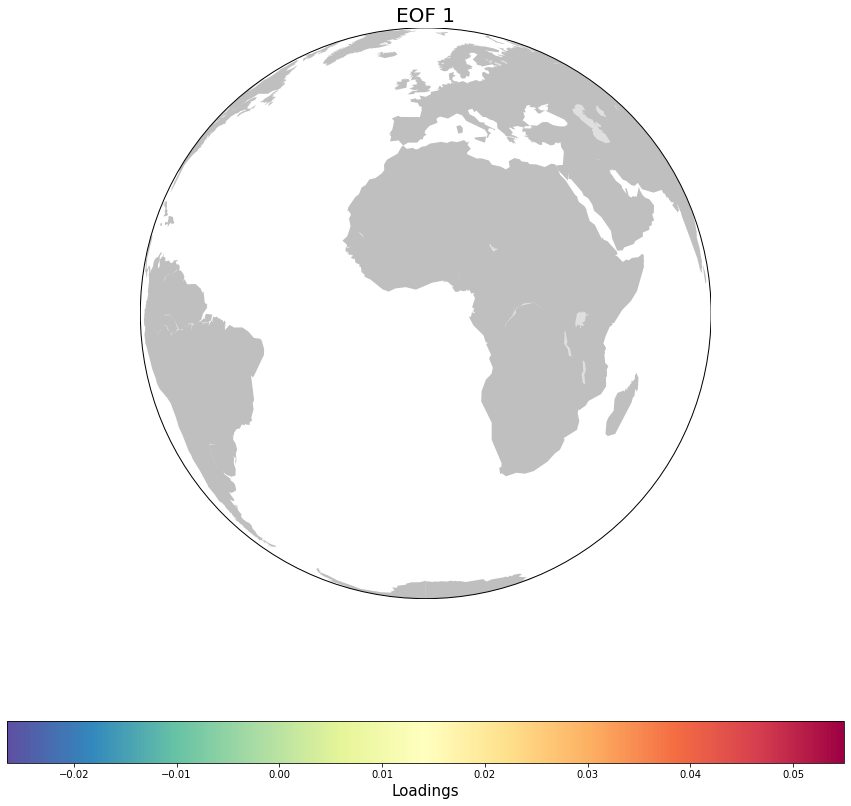

In [14]:
pc = 1
df_sst["pc"] = loading_sst[pc]


#lon1 = np.arange(-178.75,179.0,2.5)
lon1_sst = np.arange(-180,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].clusters.values.size == 0:
            deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
#map =Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
map =Basemap(projection='ortho',lon_0 = -150, lat_0 = 0)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_sst, lat_sst)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('Loadings', fontsize = 15)
plt.title("EOF %d"%(pc),fontsize = 20)
#plt.savefig("EOF%d.png"%(pc+1))
plt.show()

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


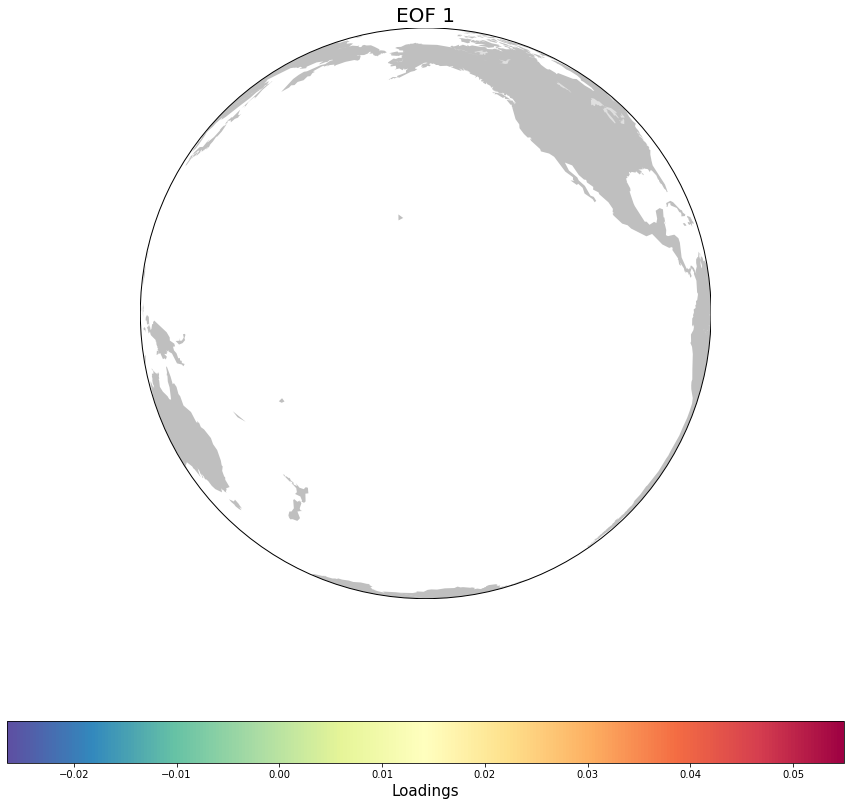

In [15]:
plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
#map =Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
map =Basemap(projection='ortho',lon_0 = -150, lat_0 = 0)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_sst, lat_sst)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('Loadings', fontsize = 15)
plt.title("EOF %d"%(pc),fontsize = 20)
#plt.savefig("EOF%d.png"%(pc+1))
plt.show()

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


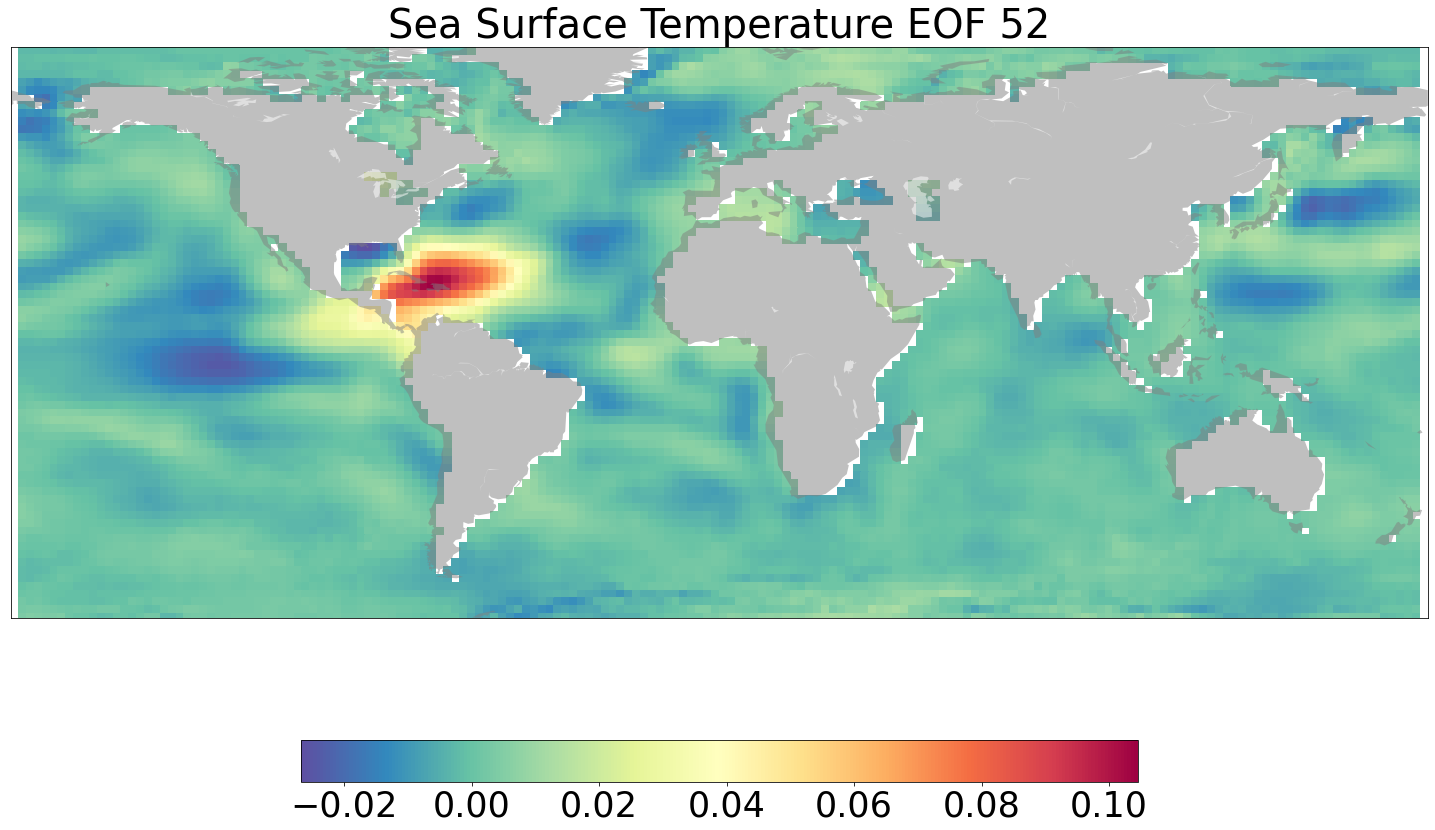

In [11]:
pc = 51
df_sst["pc"] = loading_sst[pc]


#lon1 = np.arange(-178.75,179.0,2.5)
lon1_sst = np.arange(-180,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].clusters.values.size == 0:
            deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
map =Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_sst, lat_sst)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.ax.tick_params(labelsize=35)
#plt.clim(-0.1,0.1)
#cbar.set_label('Loadings', fontsize = )
plt.title("Sea Surface Temperature EOF %d"%(pc+1),fontsize = 40)
plt.savefig("SST EOF%d.png"%(pc+1))
plt.show()

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


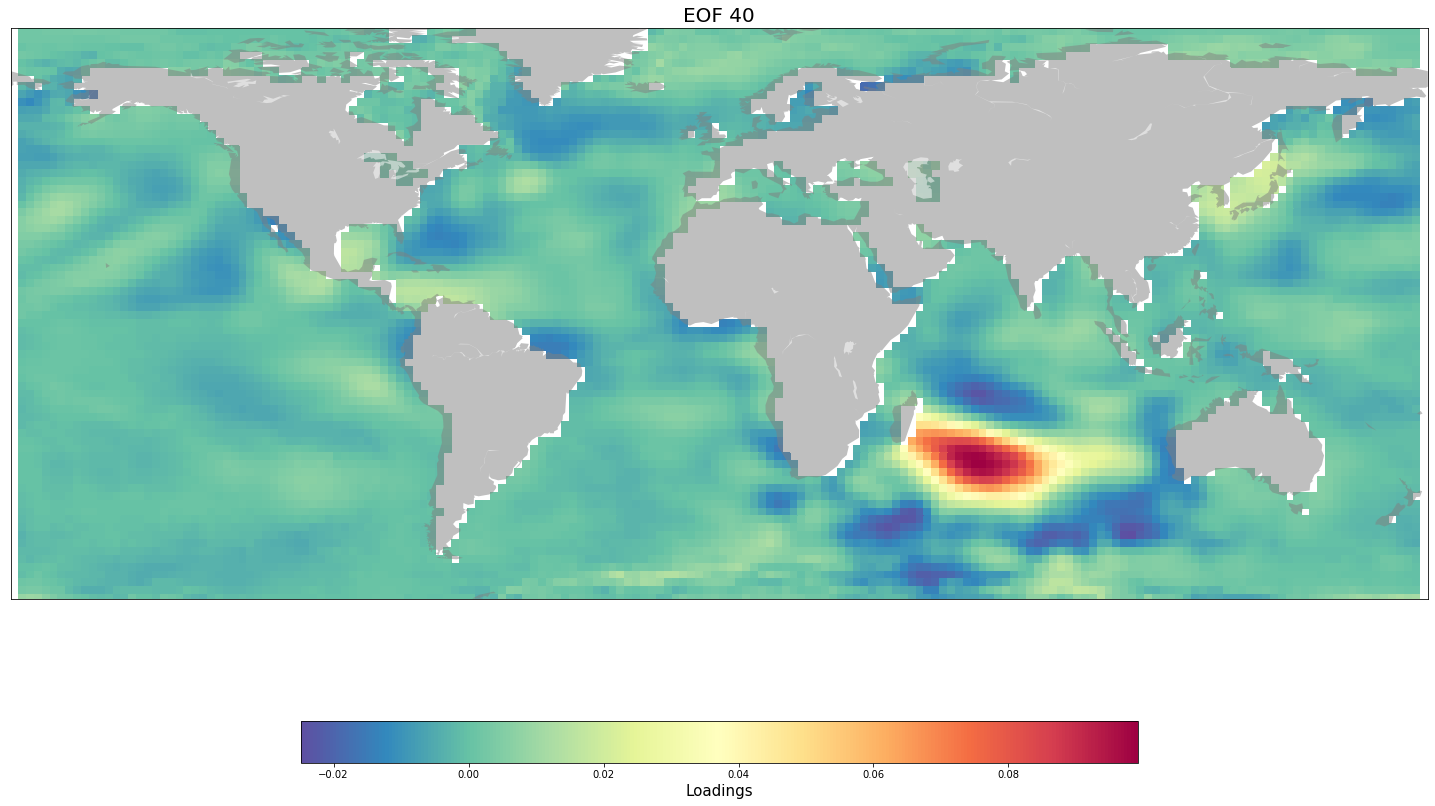

In [30]:
pc = 40
df_sst["pc"] = loading_sst[pc]


#lon1 = np.arange(-178.75,179.0,2.5)
lon1_sst = np.arange(-180,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].clusters.values.size == 0:
            deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
map =Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_sst, lat_sst)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('Loadings', fontsize = 15)
plt.title("EOF %d"%(pc),fontsize = 20)
#plt.savefig("EOF%d.png"%(pc+1))
plt.show()

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


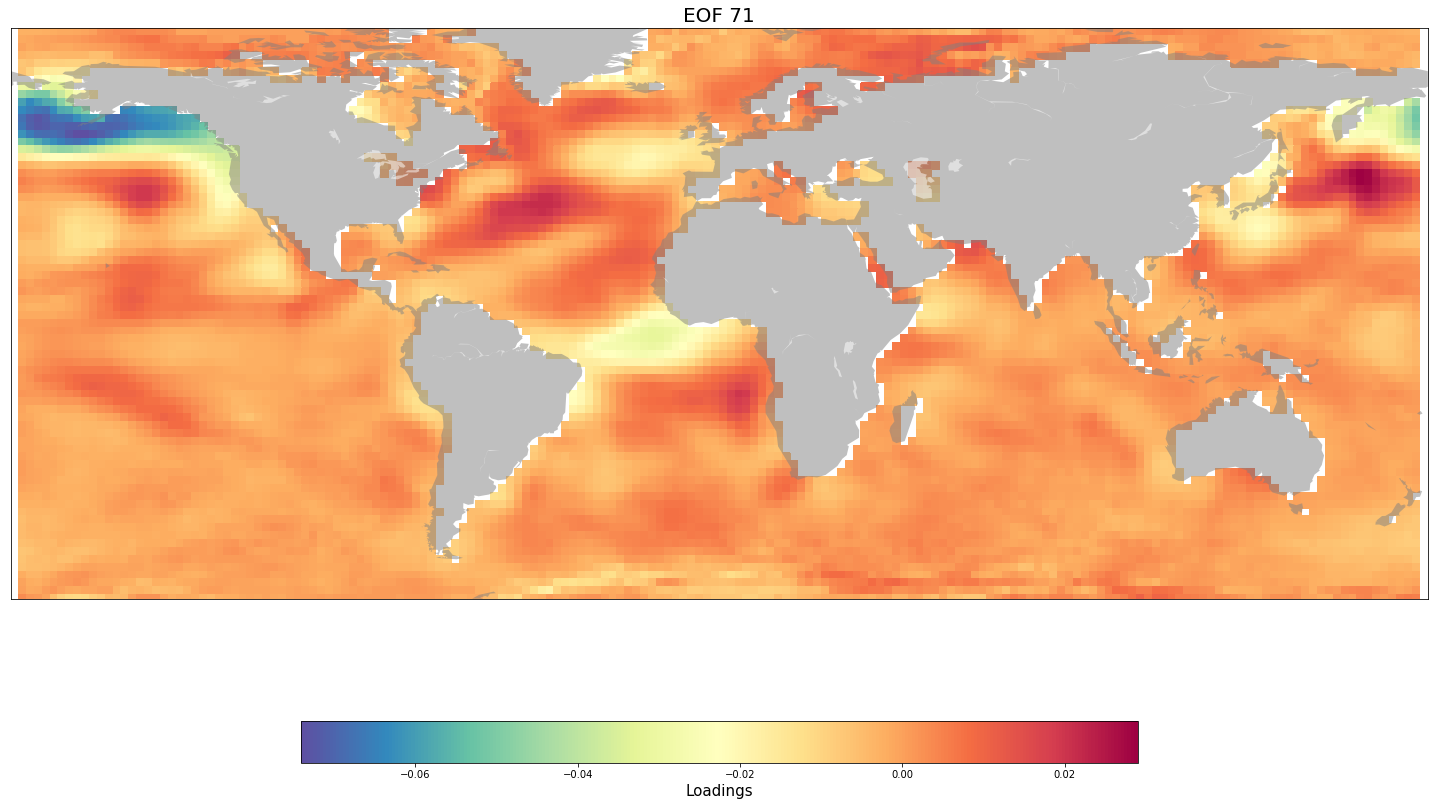

In [31]:
pc = 71
df_sst["pc"] = loading_sst[pc]


#lon1 = np.arange(-178.75,179.0,2.5)
lon1_sst = np.arange(-180,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].clusters.values.size == 0:
            deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
map =Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_sst, lat_sst)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('Loadings', fontsize = 15)
plt.title("EOF %d"%(pc),fontsize = 20)
#plt.savefig("EOF%d.png"%(pc+1))
plt.show()

In [32]:
n_components_sat = 82


sat = Data('../../nc/air.mon.mean.nc','air',temporal_limits, missing_value= -9.96921e+36)

result_sat = sat.get_data()
lon_sat_list = sat.get_lon_list()
lat_sat_list = sat.get_lat_list()
lon_sat = sat.get_lon()
lat_sat = sat.get_lat()

result_sat = pf.deseasonalize(np.array(result_sat))
weights = np.sqrt(np.abs(np.cos(np.array(lat_sat_list)* math.pi/180)))
for i in range(len(weights)):
    result_sat[:,i] = weights[i] * result_sat[:,i]

data_sat = pd.DataFrame(result_sat)


#scale = StandardScaler()
#scaled_data = scale.fit_transform(data_sat)

pca = PCA(n_components=n_components_sat)
pca_model = pca.fit(data_sat)
df_cluster_sat = pca_model.transform(data_sat)


#Matrix = pd.DataFrame(np.transpose(pca_model.components_))
#Matrix = (Matrix - Matrix.mean())/Matrix.std()
loading_sat = pf.varimax(np.transpose(pca_model.components_), q=1000)
for z in range(loading_sat.shape[1]):
    loading_sat[:,z] = loading_sat[:,z] / np.linalg.norm(loading_sat[:,z])
loading_sat = pd.DataFrame(loading_sat)

#Matrix = np.transpose(pca_model.components_)
#loading_sat = pd.DataFrame(pf.varimax(Matrix, q=1000))


clusters = loading_sat.idxmax(axis=1)
df_sat = pd.DataFrame({"lons":lon_sat_list,"lats":lat_sat_list,"clusters":clusters.values.tolist()})

lon_temp = df_sat["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sat["lons"].vlues = lon_temp

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


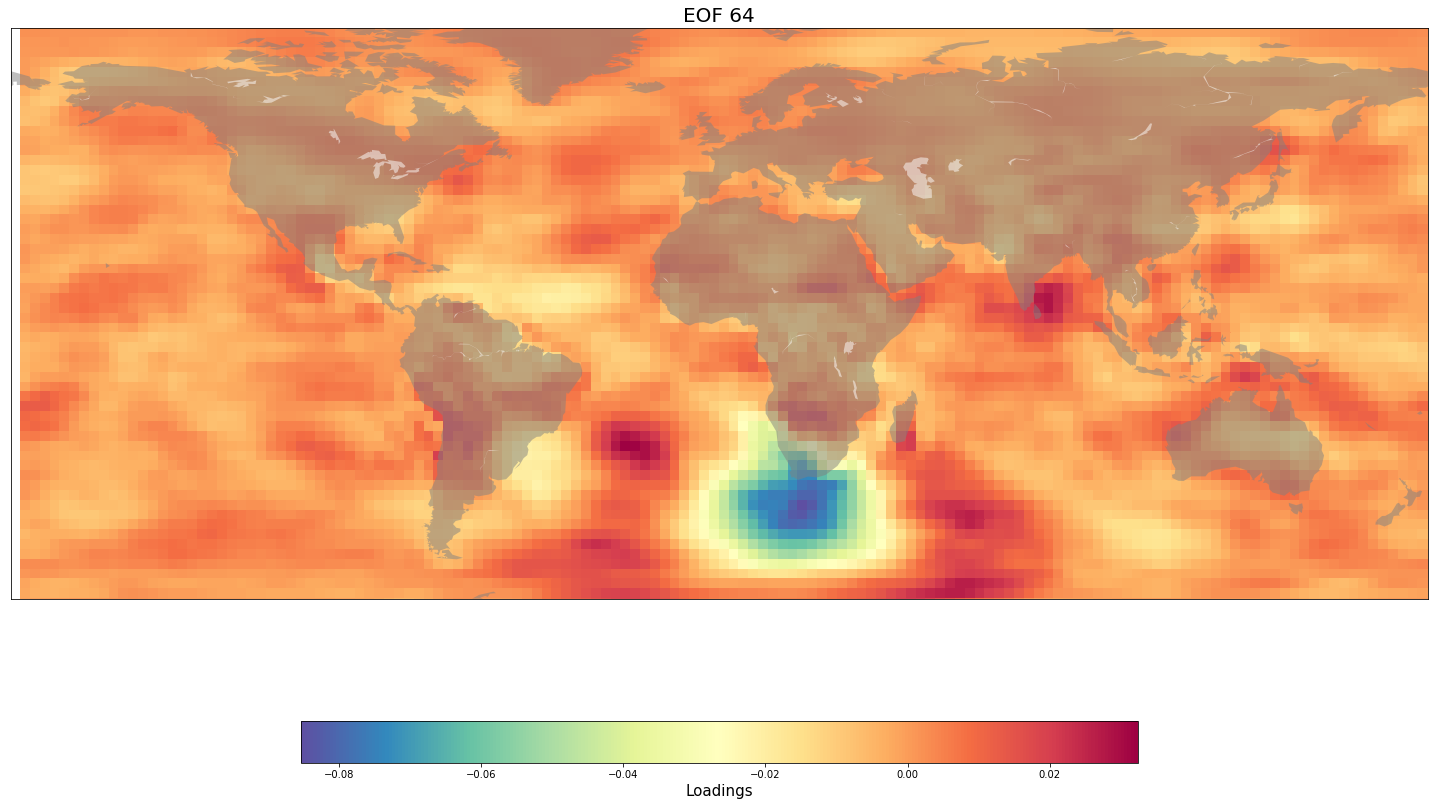

In [43]:
pc = 64
df_sat["pc"] = loading_sat[pc]


#lon1 = np.arange(-178.75,179.0,2.5)
lon1_sat = np.arange(-177.5,180.5,2.5)
#lon1_sat = np.arange(-180,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_sat),len(lon1_sat)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sat[(df_sat.lats == lat_sat[i]) & (df_sat.lons == lon1_sat[j])].clusters.values.size == 0:
            deg[i,j] = df_sat[(df_sat.lats == lat_sat[i]) & (df_sat.lons == lon1_sat[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
map =Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_sat, lat_sat)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('Loadings', fontsize = 15)
plt.title("EOF %d"%(pc),fontsize = 20)
#plt.savefig("EOF%d.png"%(pc+1))
plt.show()

In [21]:
count_name  = ["count"]

sst_name  = []
for i in range(n_components_sst):
    sst_name.append("SST_%d"%i)

pre_name  = []
for i in range(n_components_pre):
    pre_name.append("PRE_%d"%i)
#
var_names = count_name + pre_name
#

result_d = np.array(count)
result_d = result_d.reshape((len(count),1))
#result_sst = np.matrix(df_cluster_sst)
result_pre = np.array(df_cluster_pre)

result = np.concatenate((result_d,result_pre), axis=1)
result = np.array(result)

In [22]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [24]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
#save_obj(results, "results")
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable count has 7 link(s):
        (count -1): pval = 0.00000 | val = 0.673
        (PRE_5 -1): pval = 0.00000 | val = 0.257
        (PRE_1 -1): pval = 0.00000 | val = 0.220
        (PRE_4 -1): pval = 0.00755 | val = -0.126
        (PRE_9 0): pval = 0.00986 | val = 0.122
        (PRE_6 0): pval = 0.01563 | val = 0.114
        (PRE_1 -2): pval = 0.01743 | val = -0.112

    Variable PRE_0 has 6 link(s):
        (PRE_0 -1): pval = 0.00000 | val = 0.218
        (PRE_1 0): pval = 0.00012 | val = 0.181
        (PRE_4 -1): pval = 0.00820 | val = -0.125
        (PRE_6 -1): pval = 0.01113 | val = 0.119
        (PRE_3 -2): pval = 0.02105 | val = -0.109
        (PRE_0 -2): pval = 0.04321 | val = -0.096

    Variable PRE_1 has 8 link(s):
        (PRE_1 -1): pval = 0.00000 | val = 0.242
        (PRE_4 -2): pval = 0.00000 | val = 0.225
        (PRE_1 -2): pval = 0.00011 | val = 0.182
        (PRE_0 0): pval = 0.00012 | val = 0.181
        (PRE_0 -2): pv

In [73]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable count has 5 link(s):
        (count -1): pval = 0.00000 | qval = 0.00000 | val = 0.674
        (PRE_5 -1): pval = 0.00000 | qval = 0.00000 | val = 0.257
        (PRE_1 -1): pval = 0.00000 | qval = 0.00010 | val = 0.219
        (PRE_9 0): pval = 0.00256 | qval = 0.00256 | val = 0.141
        (PRE_6 0): pval = 0.01433 | qval = 0.01433 | val = 0.115

    Variable PRE_0 has 2 link(s):
        (PRE_0 -1): pval = 0.00000 | qval = 0.00009 | val = 0.221
        (PRE_1 0): pval = 0.00008 | qval = 0.00008 | val = 0.184

    Variable PRE_1 has 6 link(s):
        (PRE_1 -1): pval = 0.00000 | qval = 0.00002 | val = 0.241
        (PRE_4 -2): pval = 0.00000 | qval = 0.00007 | val = 0.226
        (PRE_0 0): pval = 0.00008 | qval = 0.00008 | val = 0.184
        (PRE_1 -2): pval = 0.00010 | qval = 0.00188 | val = 0.183
        (PRE_0 -2): pval = 0.00038 | qval = 0.00659 | val = -0.167
        (PRE_2 0): pval = 0.00092 | qval = 0.00092 | val = -0.155



In [134]:
n_components_sst = 15

sst = Data('../../nc/sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result_sst = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()


result_sst = pf.deseasonalize(np.array(result_sst))

#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result_sst)
#temp = pf.deseasonalize(result)
clustering = AgglomerativeClustering(n_clusters=n_components_sst).fit(np.transpose(temp))

df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list,"clusters":clustering.labels_})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

cluster_sst = []
for i in range(n_components_sst):
    Idx = np.where((df_sst.clusters == i).values)[0]
    r = result_sst[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    cluster_sst.append(pd.DataFrame(result_sst).mean(1))
    #scale = StandardScaler()
    #scaled_data = scale.fit_transform(data)
    #pca = PCA(n_components=n_components_sst)
    #pca_model = pca.fit(scaled_data)
    #pca_data = pca_model.transform(data)
    #cluster_sst.append(pca_data[:,0])

df_cluster_sst = pd.DataFrame(np.transpose(np.matrix(cluster_sst)))

scale = StandardScaler()
df_cluster_sst = scale.fit_transform(df_cluster_sst)

count_name  = ["count"]

sst_name  = []
for i in range(n_components_sst):
    sst_name.append("SST_%d"%i)

#
var_names = count_name + sst_name

result_d = np.array(count)
result_d = result_d.reshape((len(count),1))
result_sst = np.matrix(df_cluster_sst)

result = np.concatenate((result_d, result_sst,), axis=1)
result = np.matrix(result)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [135]:
results = pcmci.run_pcmci(tau_max=12, pc_alpha=None)

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.01)

/home/mathsys2/.local/lib/python3.6/site-packages/tigramite-4.0.0b0-py3.6-linux-x86_64.egg/tigramite/independence_tests.py:1112: RuntimeWarning: divide by zero encountered in double_scalars
  trafo_val = value * np.sqrt(deg_f/(1. - value*value))



## Significant links at alpha = 0.01:

    Variable count has 2 link(s):
        (count -1): pval = 0.00000 | val = 0.698
        (count -12): pval = 0.00000 | val = -0.270

    Variable SST_0 has 194 link(s):
        (SST_1 0): pval = 0.00000 | val = 1.000
        (SST_2 0): pval = 0.00000 | val = 1.000
        (SST_3 0): pval = 0.00000 | val = 1.000
        (SST_4 0): pval = 0.00000 | val = 1.000
        (SST_5 0): pval = 0.00000 | val = 1.000
        (SST_6 0): pval = 0.00000 | val = 1.000
        (SST_7 0): pval = 0.00000 | val = 1.000
        (SST_8 0): pval = 0.00000 | val = 1.000
        (SST_9 0): pval = 0.00000 | val = 1.000
        (SST_10 0): pval = 0.00000 | val = 1.000
        (SST_11 0): pval = 0.00000 | val = 1.000
        (SST_12 0): pval = 0.00000 | val = 1.000
        (SST_13 0): pval = 0.00000 | val = 1.000
        (SST_14 0): pval = 0.00000 | val = 1.000
        (SST_0 -1): pval = 0.00000 | val = 0.954
        (SST_1 -1): pval = 0.00000 | val = 0.954
        (SST_2

In [136]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable count has 2 link(s):
        (count -1): pval = 0.00000 | qval = 0.00000 | val = 0.698
        (count -12): pval = 0.00000 | qval = 0.00000 | val = -0.270

    Variable SST_0 has 194 link(s):
        (SST_1 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_2 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_3 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_4 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_5 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_6 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_7 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_8 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_9 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_10 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_11 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_12 0): pval = 0.00000 | q

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


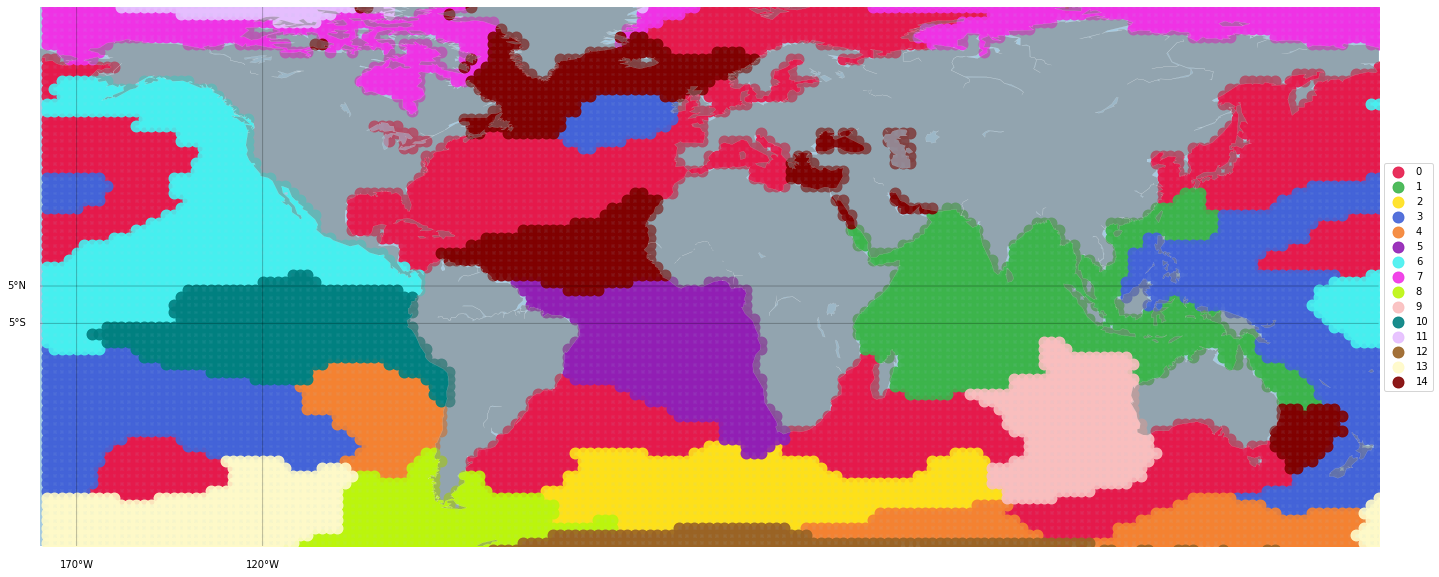

In [118]:
df_list = []
for j in range(n_components_sst):
    df_list.append(pd.DataFrame(columns=df_sst.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawparallels(np.arange(int(-5),int(10),10),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-170),int(-80),50),labels=[0,0,0,1],linewidth=0.5)

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

#colors = ['#fff7fb', '#ece7f2', '#d0d1e6', '#a6bddb', '#74a9cf', 
#'#3690c0', '#0570b0', '#045a8d', '#023858', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
#'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

#colors = color_map(np.arange(0,n_components_sst,1),cm.RdYlBu)
#'#{:02x}{:02x}{:02x}{:02x}'.format( 120, 0 , 255, 128 )

#colors = pf.random_color(n_components_sst)

for i in range(n_components_sst):
    values = df_sst["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df_sst.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=120, label = i, c = colors[i])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
#plt.legend()
plt.show()

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


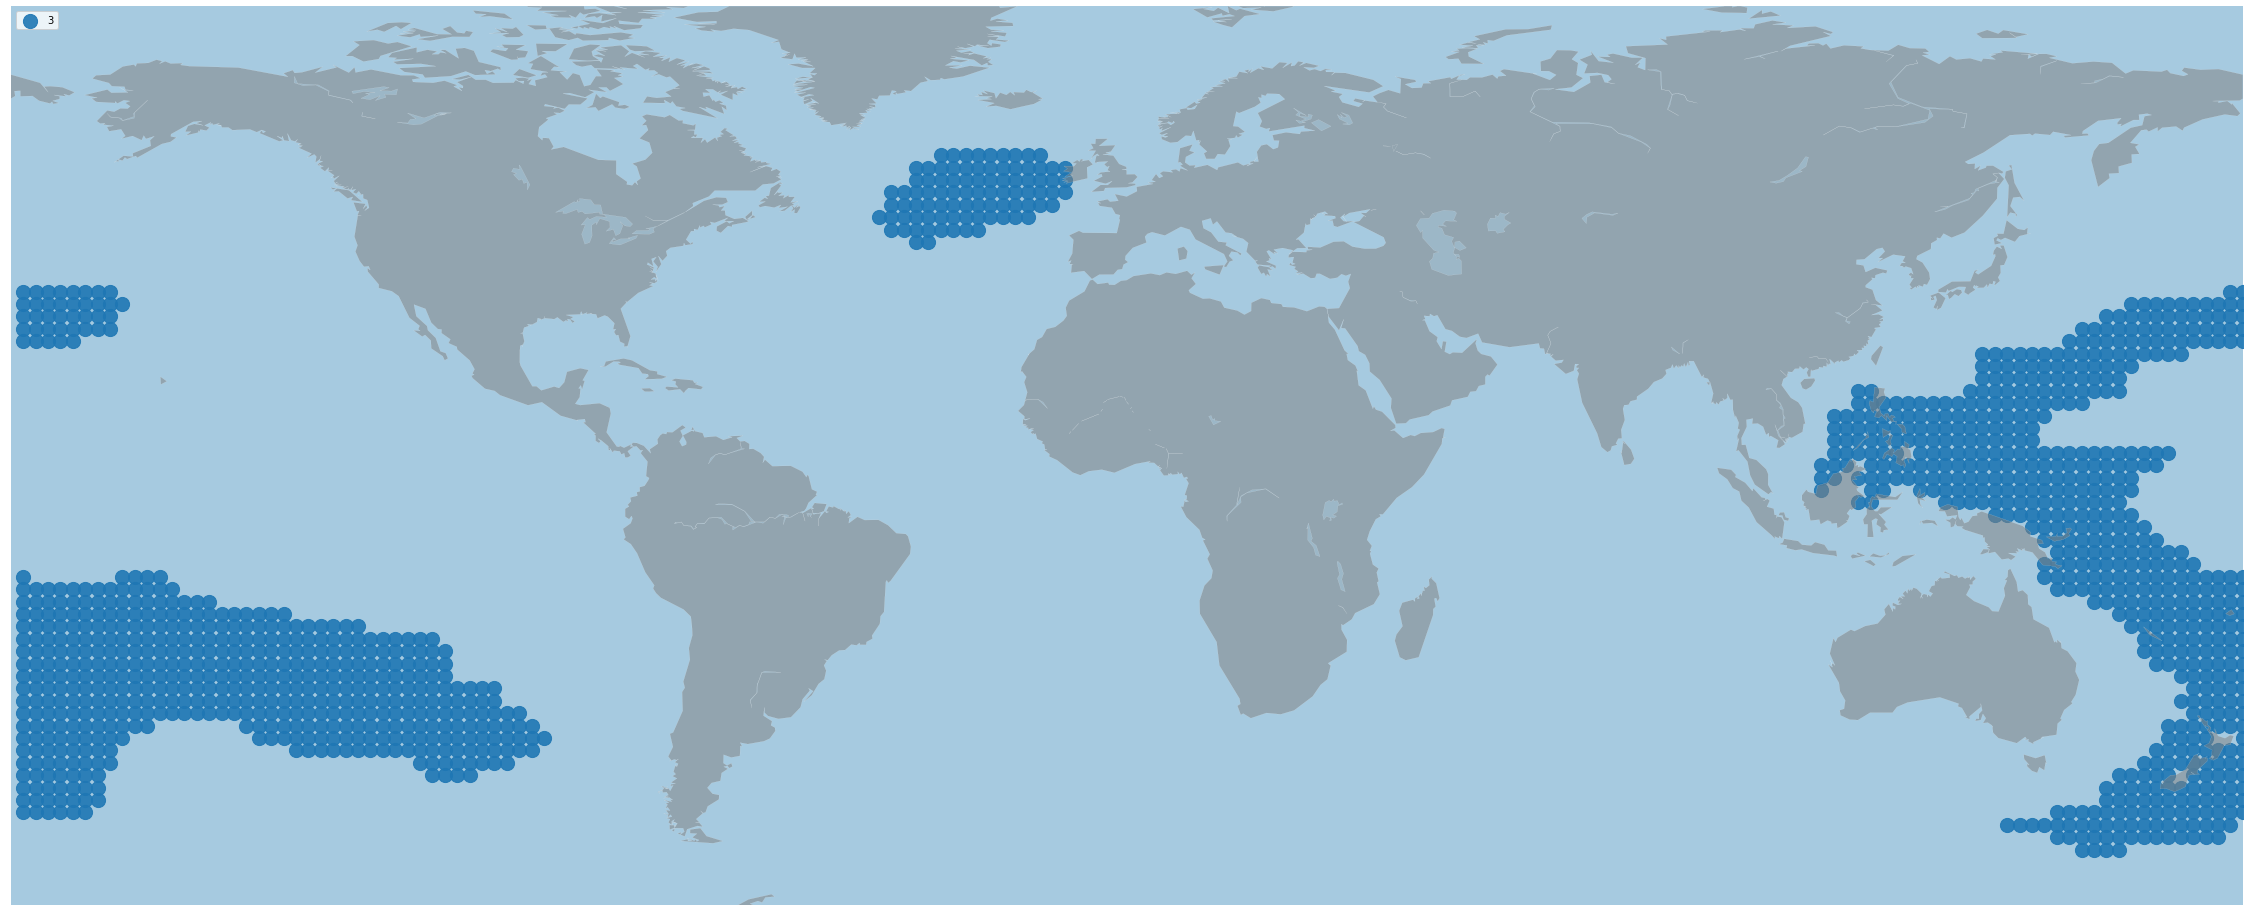

In [124]:
i = 3

df1 = df_sst[df_sst.clusters == i]

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(40,20))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")


lons = df1["lons"].values
lats = df1["lats"].values
x,y = m(lons, lats)
ax.scatter(x, y, alpha=0.9, s=200, label = i)

    
plt.legend()
plt.show()

In [41]:
min_max_scaler = preprocessing.MinMaxScaler()

In [42]:
x_scaled = min_max_scaler.fit_transform(Matrix)

In [43]:
df = pd.DataFrame(x_scaled)

In [44]:
df



,0,1,2,3,4,5,6,7,8,9
0,0.232174,0.507128,0.550462,0.598953,0.578592,0.519908,0.459239,0.458823,0.618160,0.589839
1,0.232174,0.507128,0.550462,0.598953,0.578592,0.519908,0.459239,0.458823,0.618160,0.589839
2,0.232174,0.507128,0.550462,0.598953,0.578592,0.519908,0.459239,0.458823,0.618160,0.589839
3,0.289321,0.562578,0.727303,0.222722,0.506587,0.513671,0.428408,0.490432,0.660328,0.507356
4,0.509109,0.558830,0.456644,0.615680,0.668573,0.583006,0.426213,0.531507,0.417861,0.569213
...,...,...,...,...,...,...,...,...,...,...
10983,0.331041,0.339664,0.149486,0.654869,0.583929,0.602713,0.407380,0.385180,0.548207,0.882346
10984,0.282679,0.347714,0.161898,0.691335,0.618418,0.571464,0.399623,0.378154,0.564496,0.853588
10985,0.232473,0.416850,0.193613,0.469087,0.596166,0.570314,0.432059,0.330204,0.675567,0.789316
10986,0.232293,0.466824,0.196958,0.496146,0.539074,0.548111,0.496509,0.318510,0.703613,0.683162


In [ ]:
stretched Gaussian